# FASTA extraction and filtering

In [1]:
import os.path
import numpy as np
import pandas as pd
import torch
import pickle
import subprocess
from matplotlib import pyplot as plt
from Bio import SeqIO
from importlib import reload
import warnings

from scipy.stats import mode
from sklearn.neighbors import KernelDensity
from skimage.graph import route_through_array
from scipy.spatial import cKDTree
from Bio import Entrez, SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import os

In [2]:
GT1_proteins = pd.read_csv('/Users/dahala/GitHub/VAE-enzymes/random_data/GT1.txt', sep='\t', header=None)
GT1_proteins.columns = ['type', 'organism', 'ID', 'Accession', 'database']
GT1_proteins = GT1_proteins.drop_duplicates(subset='Accession')
GT1_prot_ncbi = GT1_proteins[GT1_proteins['database'] == 'ncbi']


In [3]:
Entrez.email = "dahala@dtu.com"

def fetch_protein_sequence(accession):
    handle = Entrez.efetch(db="protein", id=accession, rettype="fasta", retmode="text")
    record = SeqIO.read(handle, "fasta")
    handle.close()
    return record

# Example usage:
acc = "BCM90193.1"  # Replace with your own accession number
protein_record = fetch_protein_sequence(acc)
print(protein_record.id)
print(protein_record.description)
print(protein_record.seq)

BCM90193.1
BCM90193.1 O-mycaminosyltylonolide 6-deoxyallosyltransferase [Abditibacteriota bacterium]
MRESALLKTLKILFSTFGSLGDIHPYVAIALEAKRRGHTPVIATSERYREKIAAQNIEFRPVAPDLPPEDEFAGLAKQVMNEKDGPRFLFEEILGPSIRTQYADLLAASEDVDLLISHPAAQTGPLVARKTGKKWLSSVLSPISLWSRRDPCVPPTLPHLDWLRVLGPLWGRIQVEAGKAATKKWVVGIEQLREEQNIEFAGHPMFGGQFSPFGTLALFSRHFCAPQPDWPQNTTATGFCFYDAVGLKSNSQPESSDWRAWMQNGSPPVVIGLGSAAVHDGAAIWDAAVRASRRDNVRVVLLTAGTFETAEENVLCVPYAPYSEIFPLARHVYHQGGVGTTAQALRAGVRQVIMPFAHDQSDNAARIQRLGVGRWMRRRELPSLNLKMTRSAWELQRFERAREIGELIRAENGPQAACESIERVGAM


In [34]:
def download_protein_sequences_to_fasta(accession_list, output_fasta, failed_log="failed_accessions.txt", batch_size=5000):
    all_sequences = []
    failed_accessions = []

    for i in range(0, len(accession_list), batch_size):
        batch = accession_list[i:i + batch_size]
        print(f"⏳ Fetching batch {i // batch_size + 1}: {len(batch)} accessions")

        try:
            ids = ",".join(batch)
            handle = Entrez.efetch(db="protein", id=ids, rettype="fasta", retmode="text")
            records = list(SeqIO.parse(handle, "fasta"))
            handle.close()
        except Exception as e:
            print(f"✗ Failed batch {i // batch_size + 1}: {e}")
            failed_accessions.extend(batch)
            continue

        fetched_ids = {record.id.split("|")[0] for record in records}
        all_sequences.extend(records)

        # Find any missing accessions in this batch
        missing = [acc for acc in batch if acc not in fetched_ids]
        if missing:
            print(f"⚠ {len(missing)} accessions not found in batch {i // batch_size + 1}")
            failed_accessions.extend(missing)

    # Write results
    if all_sequences:
        SeqIO.write(all_sequences, output_fasta, "fasta")
        print(f"\n✔ Saved {len(all_sequences)} sequences to {output_fasta}")

    if failed_accessions:
        with open(failed_log, "w") as f:
            for acc in failed_accessions:
                f.write(acc + "\n")
        print(f"⚠ {len(failed_accessions)} accessions failed. Saved to {failed_log}")

In [ ]:
#download_protein_sequences_to_fasta(GT1_prot_ncbi.Accession.tolist(), '../../random_data/GT1_ncbi.fasta', failed_log="../../random_data/GT1_failed_accessions.txt",batch_size=9000)

⏳ Fetching batch 1: 9000 accessions
⚠ 2 accessions not found in batch 1
⏳ Fetching batch 2: 9000 accessions
⚠ 2 accessions not found in batch 2
⏳ Fetching batch 3: 9000 accessions
⚠ 2 accessions not found in batch 3
⏳ Fetching batch 4: 9000 accessions
⚠ 3 accessions not found in batch 4
⏳ Fetching batch 5: 9000 accessions
⏳ Fetching batch 6: 9000 accessions
⏳ Fetching batch 7: 3400 accessions

✔ Saved 57395 sequences to ../../random_data/GT1_filtered.fasta
⚠ 9 accessions failed. Saved to ../../random_data/GT1_failed_accessions.txt


In [89]:
GT1s_fasta_path = '../../random_data/GT1_ncbi.fasta'
GT1_fastas_dict = SeqIO.to_dict(SeqIO.parse(GT1s_fasta_path, "fasta"))


In [90]:
GT1_fastas_array = []
GT1_fastas_len = []
for acc, item in GT1_fastas_dict.items():
    seq = str(item.seq)
    if len(seq) > 0:
        GT1_fastas_array.append(seq)
        GT1_fastas_len.append(len(seq))
    else:
        print(f"⚠ Empty sequence for {acc}")
GT1_fastas_array = np.array(GT1_fastas_array)
GT1_fastas_len = np.array(GT1_fastas_len)

(array([5.578e+04, 1.155e+03, 3.190e+02, 2.400e+01, 9.000e+00, 1.000e+00,
        1.000e+00, 9.500e+01, 8.000e+00, 1.200e+01]),
 array([  30.,  647., 1264., 1881., 2498., 3115., 3732., 4349., 4966.,
        5583., 6200.]),
 <BarContainer object of 10 artists>)

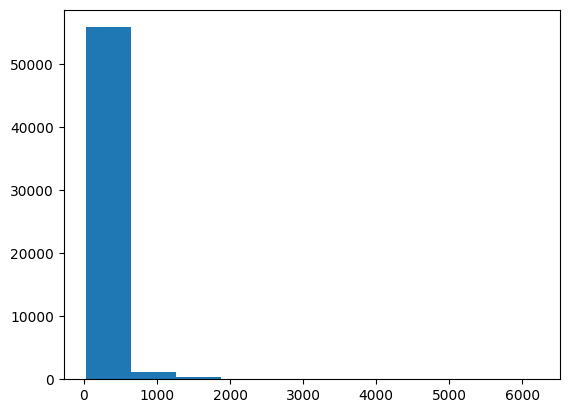

In [91]:
plt.hist(GT1_fastas_len)

In [92]:
# Finding the longest sequence
max_len = 0
max_acc = ''
for acc, item in GT1_fastas_dict.items():
    seq = str(item.seq)
    if len(seq) > max_len:
        max_len = len(seq)
        max_acc = acc
print(f"Longest sequence is {max_acc} with length {max_len}")

# Finding sequences above 1000
long_sequences = []
for acc, item in GT1_fastas_dict.items():
    seq = str(item.seq)
    if len(seq) > 1000:
        long_sequences.append(acc)
print(f"Sequences above 1000: {len(long_sequences)}")
# Finding sequences above 2000
long_sequences = []
for acc, item in GT1_fastas_dict.items():
    seq = str(item.seq)
    if len(seq) > 2000:
        long_sequences.append(acc)
print(f"Sequences above 2000: {len(long_sequences)}")


Longest sequence is UIA10484.1 with length 6200
Sequences above 1000: 842
Sequences above 2000: 143


In [93]:
GT1_fastas_dict_filtered = {}
for acc, item in GT1_fastas_dict.items():
    seq = str(item.seq)
    if len(seq) < 1000:
        GT1_fastas_dict_filtered[acc] = item

In [94]:
GT1_fastas_array = []
GT1_fastas_len = []
for acc, item in GT1_fastas_dict_filtered.items():
    seq = str(item.seq)
    if len(seq) > 0:
        GT1_fastas_array.append(seq)
        GT1_fastas_len.append(len(seq))
    else:
        print(f"⚠ Empty sequence for {acc}")
GT1_fastas_array = np.array(GT1_fastas_array)
GT1_fastas_len = np.array(GT1_fastas_len)

(array([ 1190.,  5957.,  2674., 20662., 21916.,  3143.,   387.,   233.,
          253.,   145.]),
 array([ 30. , 126.9, 223.8, 320.7, 417.6, 514.5, 611.4, 708.3, 805.2,
        902.1, 999. ]),
 <BarContainer object of 10 artists>)

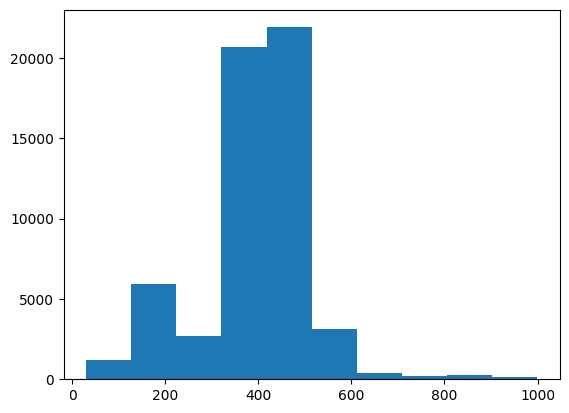

In [95]:
plt.hist(GT1_fastas_len)

In [96]:
# Finding sequences below 100
short_sequences = []
for acc, item in GT1_fastas_dict_filtered.items():
    seq = str(item.seq)
    if len(seq) < 100:
        short_sequences.append(acc)
print(f"Sequences below 100: {len(short_sequences)}")
# Finding sequences above 100 and below 200
short_sequences = []
for acc, item in GT1_fastas_dict_filtered.items():
    seq = str(item.seq)
    if len(seq) < 200 and len(seq) > 100:
        short_sequences.append(acc)
print(f"Sequences above 100 and below 200: {len(short_sequences)}")
# Finding sequences above 200 and below 300
short_sequences = []
for acc, item in GT1_fastas_dict_filtered.items():
    seq = str(item.seq)
    if len(seq) < 300 and len(seq) > 200:
        short_sequences.append(acc)
print(f"Sequences above 200 and below 300: {len(short_sequences)}")

Sequences below 100: 618
Sequences above 100 and below 200: 5717
Sequences above 200 and below 300: 2582


In [104]:
GT1_fastas_dict_filtered = {}
for acc, item in GT1_fastas_dict.items():
    seq = str(item.seq)
    if len(seq) > 200 and len(seq) < 1000:
        GT1_fastas_dict_filtered[acc] = item
GT1s_filtered_fasta_path = '../../random_data/GT1_ncbi_filtered.fasta'
SeqIO.write(GT1_fastas_dict_filtered.values(), GT1s_filtered_fasta_path, "fasta")

50169

In [111]:
GT1_prot_ncbi[GT1_prot_ncbi.ID.str.contains('Arabidopsis thaliana')]

,type,organism,ID,Accession,database
3597,GT1,Eukaryota,Arabidopsis thaliana,AAB61023.1,ncbi
3598,GT1,Eukaryota,Arabidopsis thaliana,AAK25972.1,ncbi
3599,GT1,Eukaryota,Arabidopsis thaliana,AAK64133.1,ncbi
3600,GT1,Eukaryota,Arabidopsis thaliana,AAM61455.1,ncbi
3601,GT1,Eukaryota,Arabidopsis thaliana,ABJ18919.1,ncbi
...,...,...,...,...,...
4400,GT1,Eukaryota,Arabidopsis thaliana,BAF01562.1,ncbi
4401,GT1,Eukaryota,Arabidopsis thaliana,CAB10446.1,ncbi
4402,GT1,Eukaryota,Arabidopsis thaliana,CAB78713.1,ncbi
4403,GT1,Eukaryota,Arabidopsis thaliana,NP_193404.1,ncbi


In [116]:
query_seq = 'MKVELVFIPSPGVGHIRATTALAKLLVASDNRLSVTLIVIPSRVSDDASSSVYTNSEDRLRYILLPARDQTTDLVSYIDSQKPQVRAVVSKVAGDVSTRSDSRLAGIVVDMFCTSMIDIADEFNLSAYIFYTSNASYLGLQFHVQSLYDEKELDVSEFKDTEMKFDVPTLTQPFPAKCLPSVMLNKKWFPYVLGRARSFRATKGILVNSVADMEPQALSFFSGGNGNTNIPPVYAVGPIMDLESSGDEEKRKEILHWLKEQPTKSVVFLCFGSMGGFSEEQAREIAVALERSGHRFLWSLRRASPVGNKSNPPPGEFTNLEEILPKGFLDRTVEIGKIISWAPQVDVLNSPAIGAFVTHCGWNSILESLWFGVPMAAWPIYAEQQFNAFHMVDELGLAAEVKKEYRRDFLVEEPEIVTADEIERGIKCAMEQDSKMRKRVMEMKDKLHVALVDGGSSNCALKKFVQDVVDNVP'
for acc, item in GT1_fastas_dict.items():
    seq = str(item.seq)
    if query_seq in seq:
        print(f"Found query_seq in {acc}")
        break
else:
    print(f"{query_seq} not found in any sequence")

Found query_seq in AEE76548.1


# VAE analysis

In [118]:
import os.path
import numpy as np
import pandas as pd
import torch
import pickle
import subprocess
from matplotlib import pyplot as plt
from Bio import SeqIO
from importlib import reload
import warnings

from scipy.stats import mode
from sklearn.neighbors import KernelDensity
from skimage.graph import route_through_array
from scipy.spatial import cKDTree

import matplotlib.cm as cm

import minimal_version.parser_handler
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/
from minimal_version.preprocess_msa import Preprocessor, weight_sequences
from minimal_version.msa import MSA
from minimal_version.utils import Capturing, store_to_pkl, store_to_fasta, load_from_pkl

from minimal_version.train import setup_train, Train

%cd /Users/dahala/GitHub/VAE-enzymes/
from custom_functions import *
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


In [124]:
CONFIGURATION_FILE = "msaCazy_GT1_trim_200_1000_GASPhmm.json"
run = minimal_version.parser_handler.RunSetup(CONFIGURATION_FILE)
print(f" Working with {CONFIGURATION_FILE} configuration file!")
PFAM_INPUT = False

Configuration file stored in ../results/Cazy_GT1_trim_200_1000_GASPhmm/config/2025-03-31_16-52.json
 Working with msaCazy_GT1_trim_200_1000_GASPhmm.json configuration file!


In [121]:
HMMbuild = HMMmodule(run)
#HMMbuild.build()
HMMbuild.align('GT1_ncbi_filtered_200_1000',fasta_ext='fasta')

In [125]:
"""
Preprocess MSA and prepare it for VAE model training
"""

# logging
msa_log = open(os.path.join(run.logs, 'msa_log.txt'), "w")

# MSA loading
if PFAM_INPUT:
    msa = MSA.load_pfam(run.dataset)
else:
    msa = MSA.load_msa(run.dataset)
MSA.amino_acid_dict(run.pickles)
msg = f"MSA in {run.dataset} loaded\n" \
      f"number of sequences: {len(list(msa.keys()))}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')

# MSA preprocessing
preprocessor = Preprocessor(run)
with Capturing() as output:
    msa, msa_keys = preprocessor.trim_msa(msa)
msa_log.write(" MSA Preprocessing \n" + "\n".join(output) + f'\n{"="*80}\n')
assert (msa.shape[0] == len(msa_keys))
trim_file_path = os.path.join(run.msa, "trimmed_msa.fasta")
msg = f"Trimmed MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Trimmed MSA is stored at {trim_file_path}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')
msa_num_dict_shuffled = {k: seq for k, seq in zip(msa_keys, msa)}  # transform to dictionary, have keys together
# but secure that query and fixed sequences are at the beginning 
msa_num_dict = {k: msa_num_dict_shuffled[k] for k in preprocessor.keep_keys}
msa_num_dict.update({k: msa_num_dict_shuffled[k] for k in msa_num_dict_shuffled if k not in preprocessor.keep_keys})

trimmed_msa = MSA.number_to_amino(msa_num_dict)
store_to_fasta(trimmed_msa, trim_file_path)
store_to_pkl({run.query: trimmed_msa[run.query]}, os.path.join(run.pickles, "reference_seq.pkl"))

# Filtering or weighting
with Capturing() as output:
    if run.clustering:  # MSA filtering
        print(f"MSA {run.identity}% identity filtering step")
        msa_num_dict = preprocessor.identity_filtering(msa_num_dict)
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = np.ones(msa.shape[0])  # we just provide uniform weights for all sequences
    else:  # otherwise the weighting mechanism will be applied
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = weight_sequences(msa)
msa_log.write("\n".join(output))
train_msa_file_path = os.path.join(run.msa, "training_msa.fasta")
training_alg = MSA.number_to_amino(training_alg)
store_to_fasta(training_alg, train_msa_file_path)
msg = f"Training MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Training MSA is stored at {train_msa_file_path}"
print(msg)
msa_log.write(msg + f'\n{"=" * 80}\n')

store_to_pkl(seq_weight, os.path.join(run.pickles, "seq_weight.pkl"))
store_to_pkl(training_alg, os.path.join(run.pickles, "training_alignment.pkl"))

# MSA one-hot encoding
binary = MSA.number_to_binary(msa)
store_to_pkl(binary, os.path.join(run.pickles, "seq_msa_binary.pkl"))
msa_log.close()

MSA in ../datasets/Cazy_GT1_trim_200_1000_GASPhmm_fix.afa loaded
number of sequences: 50169
Trimmed MSA has 26881 sequences and the width is 439
Trimmed MSA is stored at ../results/Cazy_GT1_trim_200_1000_GASPhmm/msa/trimmed_msa.fasta
Training MSA has 26881 sequences and the width is 439
Training MSA is stored at ../results/Cazy_GT1_trim_200_1000_GASPhmm/msa/training_msa.fasta


In [126]:
with open(run.pickles+ "/msa_columns.pkl", "rb") as input_file:
   msa_columns = pickle.load(input_file)

In [ ]:
load_from_pkl(os.path.join(run.model, "model_params.pkl"))['model']

In [ ]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)


fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)
ax.scatter(query_coords[:, 0], query_coords[:, 1], marker='o', s=100, color='red', label='Query',zorder=1)

# Project 
ax.legend(loc='lower left', fontsize=20)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)

plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, f"latent_space.png"))
    #ax.set_title(f"Latent space projection final")